# CIFAR10 Classification

### HW2 @ DL Course, Dr. Soleymani

*Full Name:* Ali Alvandi

*SID:* 400104748

In this part of the assignment we want to do an image classification task using PyTorch on CIFAR10 dataset.

## Import Libraries

Import needed libraries

In [1]:
!pip install torchsummary

In [2]:
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader, random_split
import numpy as np
from matplotlib import pyplot as plt
import torch.nn as nn
from torchsummary import summary
import torch.optim as optim
from datetime import datetime
import tqdm
import torch.nn.functional as F
from sklearn.manifold import TSNE
import pandas as pd
import seaborn as sns
from torchvision.datasets import CIFAR10

## Device

Set device to work with (GPU or CPU)

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## Transforms & Dataset & Dataloader

Here, you should download and load the dataset with the desire transforms. After that, you should split train dataset to train and validation sets. Finally, define the dataloaders for `train`, `validation` and `test`

In [4]:
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [5]:
means = (0.4914, 0.4822, 0.4465)
stds = (0.2023, 0.1994, 0.2010)

transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(), #vase generalize
    transforms.RandomCrop(32, padding=4), #pad kardim ke gooshe ha ham beioofte
    transforms.ToTensor(),
    transforms.Normalize(mean=means, std=stds)  # CIFAR-10 mean and std
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=means, std=stds)
])

all_dataset = torchvision.datasets.CIFAR10(root='./', download=True, train=True, transform=transform_train)
test_dataset = torchvision.datasets.CIFAR10(root='./', download=True, train=False, transform=transform_test)

train_dataset, val_dataset = random_split(all_dataset, [8 * len(all_dataset) // 10, 2 * len(all_dataset) // 10])

train_loader = torch.utils.data.DataLoader(train_dataset, shuffle=True, num_workers=2, batch_size=32)
valid_loader = torch.utils.data.DataLoader(val_dataset, shuffle=False, num_workers=2, batch_size=32)
test_loader = torch.utils.data.DataLoader(test_dataset, shuffle=False, num_workers=2, batch_size=32)



100%|██████████| 170498071/170498071 [00:01<00:00, 105588379.56it/s]


Extracting ./cifar-10-python.tar.gz to ./
Files already downloaded and verified


In [6]:
# inverse the normilize transform to restore the original data
class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        """
        Args:
            tensor (Tensor): Tensor image of size (C, H, W) to be normalized.
        Returns:
            Tensor: Normalized image.
        """
        #TODO
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
        return tensor

norminv = UnNormalize(means, stds)

## Visualization

Visualize 5 random images from each class in different columns

- **Hint**:  You can use `plt.subplots` for visualization

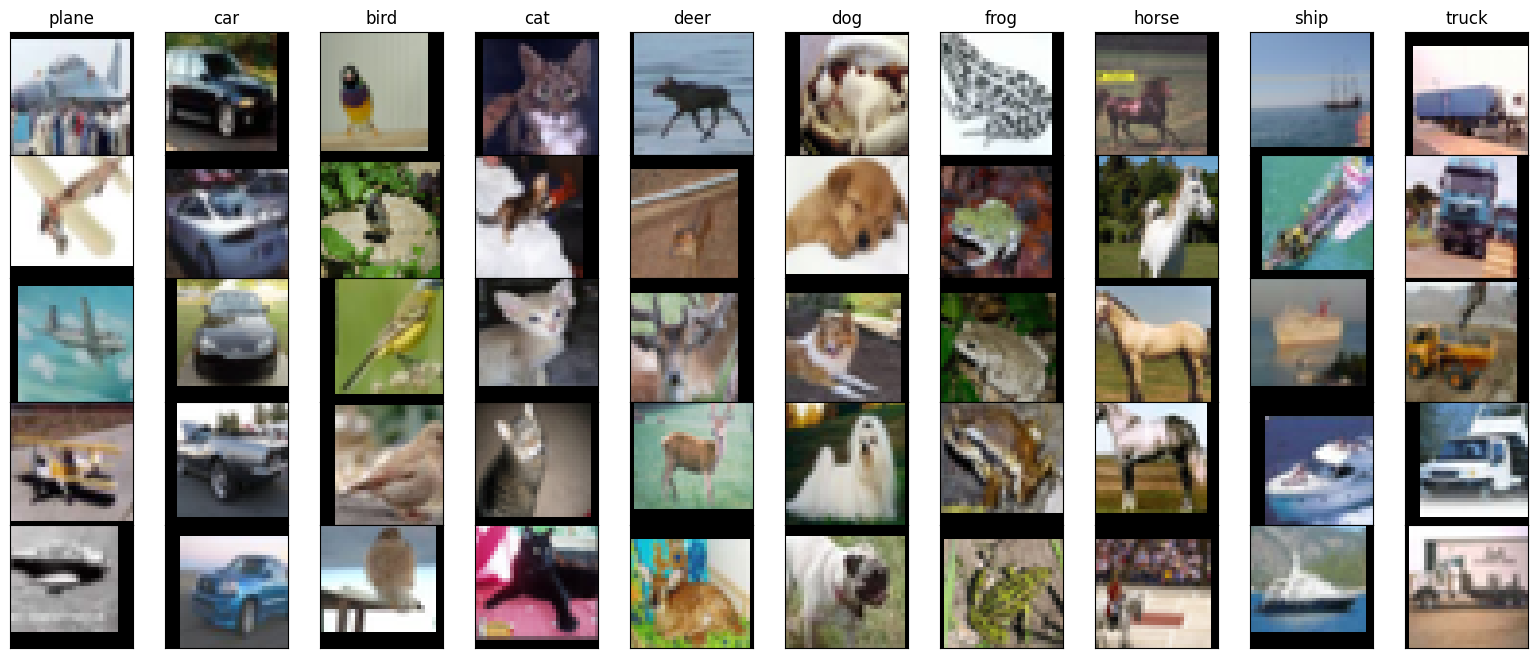

In [7]:
# TODO
class_cnt = np.zeros(len(classes))
class_images = [[] for _ in range(len(classes))]
for images, labels in train_loader:
    for img, label in zip(images, labels):
        class_images[label].append(img)
        class_cnt[label] += 1
    if class_cnt.min() >= 5:
        break
figs, axs = plt.subplots(5, len(classes), sharex=True, sharey=True, figsize=(20, 8))
for class_idx in range(len(classes)):
    for i in range(5):
        axs[i, class_idx].imshow(np.clip((norminv(class_images[class_idx][i])).permute(1,2,0), 0,1))
        axs[i, class_idx].get_xaxis().set_visible(False)
        axs[i, class_idx].get_yaxis().set_visible(False)
    axs[0, class_idx].set_title(classes[class_idx])

plt.subplots_adjust(wspace=0, hspace=0)

## Model

Define your ResNet model here from scratch (You are not allowed to use the existing models in pytorch)

Our suggestion is to implement ResNet18

In [8]:

class ResNetBlock(torch.nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResNetBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = None
        if stride != 1 or in_channels != out_channels:
            self.downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels))

    def forward(self, x):
        identity = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        if self.downsample is not None:
            identity = self.downsample(x)
        out += identity
        out = self.relu(out)
        return out

class ResNet18(torch.nn.Module):
    def __init__(self, num_classes=10):
        super(ResNet18, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self.make_layer(ResNetBlock, 64, 2, stride=1)
        self.layer2 = self.make_layer(ResNetBlock, 128, 2, stride=2)
        self.layer3 = self.make_layer(ResNetBlock, 256, 2, stride=2)
        self.layer4 = self.make_layer(ResNetBlock, 512, 2, stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)
    
    def make_layer(self, block, channels, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_channels, channels, stride))
            self.in_channels = channels
        return nn.Sequential(*layers)

    
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

## Train

### Model instantiation

Create an instance of your model and move it to `device`

In [9]:
model = ResNet18()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Model moved to device: {device}")
model = model.to(device)
summary(model, input_size=(3, 32, 32))

Model moved to device: cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4           [-1, 64, 32, 32]          36,864
       BatchNorm2d-5           [-1, 64, 32, 32]             128
              ReLU-6           [-1, 64, 32, 32]               0
            Conv2d-7           [-1, 64, 32, 32]          36,864
       BatchNorm2d-8           [-1, 64, 32, 32]             128
              ReLU-9           [-1, 64, 32, 32]               0
      ResNetBlock-10           [-1, 64, 32, 32]               0
           Conv2d-11           [-1, 64, 32, 32]          36,864
      BatchNorm2d-12           [-1, 64, 32, 32]             128
             ReLU-13           [-1, 64, 32, 32]               0
           

### Criterion & Optimizater

Define `criterion` and `optimizer` (Or `scheduler`)

In [10]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

### Train loop

Train your model

Tasks:
- [ ] Things that are needed to be printed in each epoch:
  - Number of epoch
  - Train loss
  - Train accuracy
  - Validation loss
  - Validation accuracy
- [ ] save train/validation loss and accuracy (of each epoch) in an array for later usage

In [ ]:
import tqdm
def train_epoch(net: torch.nn.Module, criterion: torch.nn.Module, optimizer: torch.optim.Optimizer, scheduler: torch.optim.lr_scheduler ,dataloader: torch.utils.data.DataLoader):
    net.train()
    running_loss = 0.0
    correct = 0
    total = 0
    pbar = tqdm(dataloader, desc="Training", leave=False)
    for inputs, targets in pbar:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == targets).sum().item()
        total += targets.size(0)
        running_loss += loss.item()
        pbar.set_postfix({'loss': running_loss / len(dataloader), 'accuracy': 100. * correct / total})

    train_loss = running_loss / len(dataloader.dataset)
    train_accuracy = 100. * correct / total
    scheduler.step()
    return train_loss, train_accuracy


def eval_epoch(net: torch.nn.Module, criterion: torch.nn.Module, dataloader: torch.utils.data.DataLoader, test_mode: bool = False):
    net.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    pbar = tqdm(dataloader, desc="Validation" if not test_mode else "Testing", leave=False)
    with torch.no_grad():
        for inputs, targets in pbar:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, targets)
            running_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
            pbar.set_postfix({'loss': running_loss / len(dataloader), 'accuracy': 100 * correct / total})
    val_loss = running_loss / len(dataloader.dataset)
    val_accuracy = 100. * correct / total
    return val_loss, val_accuracy


In [13]:
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

epochs = 10

for epoch in range(epochs):
    print(f'Epoch {epoch+1}/{epochs}:')
    train_loss, train_accuracy = train_epoch(model, criterion, optimizer, scheduler, train_loader)
    val_loss, val_accuracy = eval_epoch(model, criterion, valid_loader)
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    print(f'Train Loss: {train_loss:.4f} | Train Accuracy: {train_accuracy:.2f}%')
    print(f'Validation Loss: {val_loss:.4f} | Validation Accuracy: {val_accuracy:.2f}%')


Epoch 1/10:
Train Loss: 0.0277 | Train Accuracy: 68.73%
Validation Loss: 0.7821 | Validation Accuracy: 71.78%
Epoch 2/10:
Train Loss: 0.0231 | Train Accuracy: 74.22%
Validation Loss: 0.7338 | Validation Accuracy: 74.15%
Epoch 3/10:
Train Loss: 0.0201 | Train Accuracy: 77.58%
Validation Loss: 0.6460 | Validation Accuracy: 77.26%
Epoch 4/10:
Train Loss: 0.0180 | Train Accuracy: 79.67%
Validation Loss: 0.5560 | Validation Accuracy: 81.10%
Epoch 5/10:
Train Loss: 0.0138 | Train Accuracy: 84.76%
Validation Loss: 0.4643 | Validation Accuracy: 83.97%
Epoch 6/10:
Train Loss: 0.0130 | Train Accuracy: 85.67%
Validation Loss: 0.4466 | Validation Accuracy: 84.81%
Epoch 7/10:
Train Loss: 0.0125 | Train Accuracy: 86.17%
Validation Loss: 0.4429 | Validation Accuracy: 85.00%
Epoch 8/10:
Train Loss: 0.0121 | Train Accuracy: 86.80%
Validation Loss: 0.4312 | Validation Accuracy: 85.46%
Epoch 9/10:
Train Loss: 0.0119 | Train Accuracy: 86.81%
Validation Loss: 0.4399 | Validation Accuracy: 85.42%
Epoch 10/1

### Visualize Loss and Accuracy plot

Using the arrays that you have (from task 2 in the above section), visualize two plots: Accuracy plot (train and validation together) and Loss plot (train and validation together)

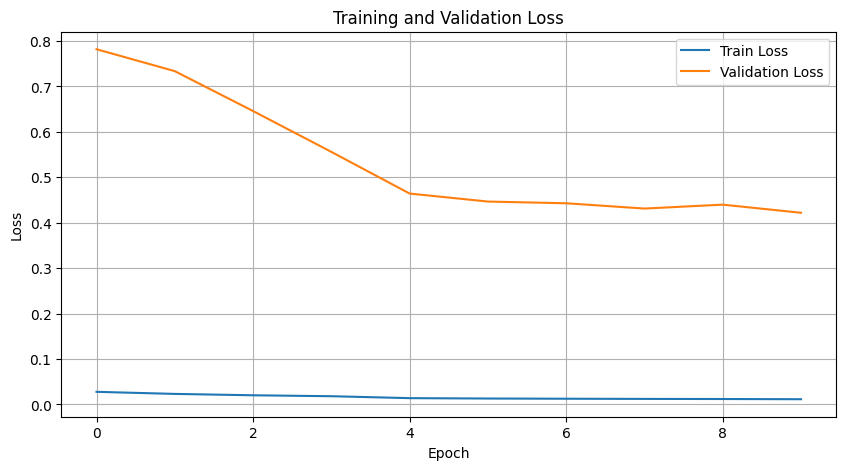

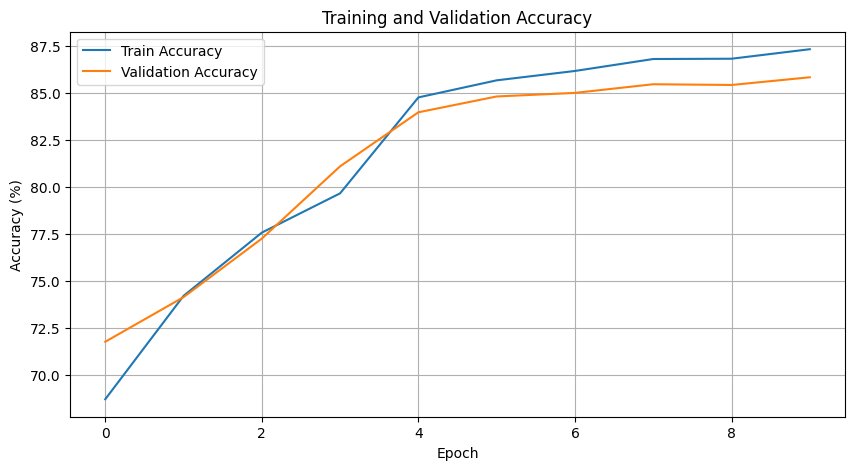

In [14]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()

## Evaluation

Test your trained model (using the Test Dataloader that you have). Our goal is to reach an accuracy above `80%`

In [15]:
def test_model(net, criterion, dataloader, device):
    net.eval()
    correct = 0
    total = 0
    test_loss = 0
    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, targets)
            test_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

    test_loss /= len(dataloader.dataset)
    test_accuracy = 100. * correct / total
    return test_loss, test_accuracy

test_loss, test_accuracy = test_model(model, criterion, test_loader, device)
print(f'Test Loss: {test_loss:.4f} | Test Accuracy: {test_accuracy:.2f}%')


Test Loss: 0.4192 | Test Accuracy: 85.79%


## Visualize incorrectly predicted samples from testset

Visualize *24* random images from testset that are incorrectly predicted by the model

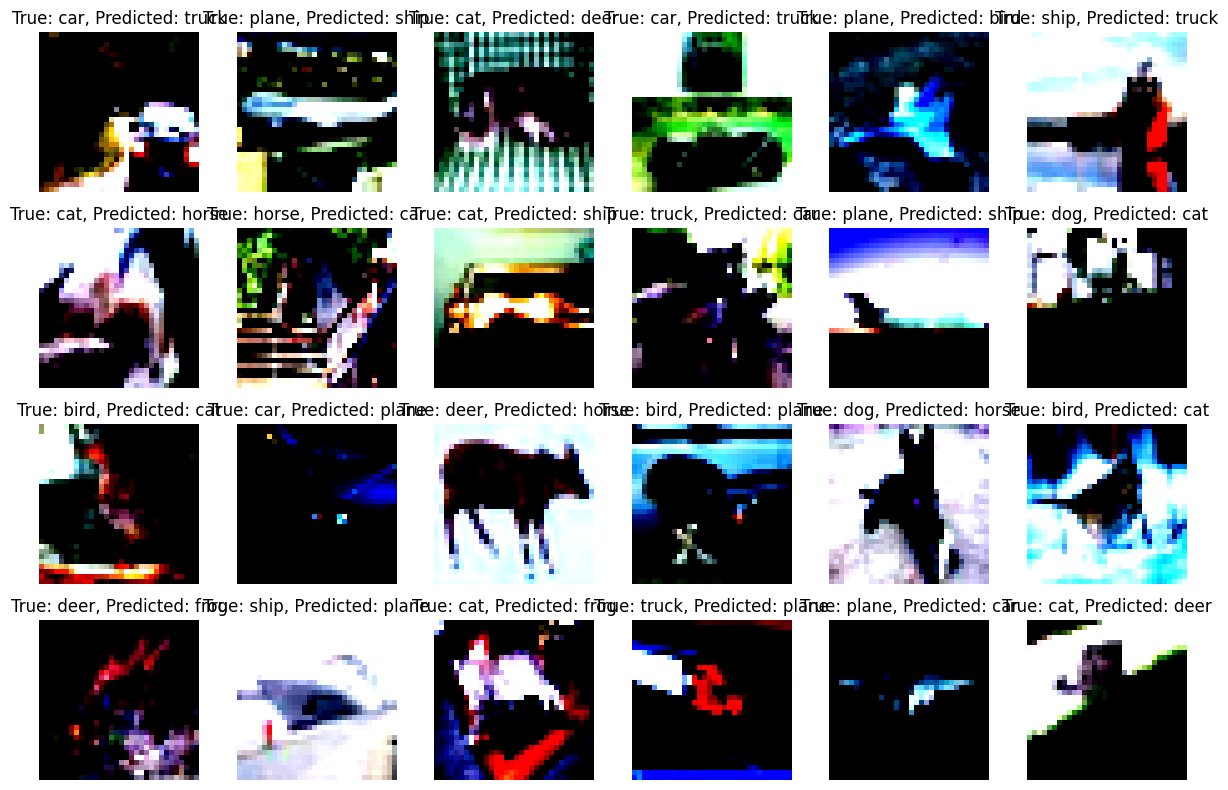

In [17]:
import random

def test_model(net, dataloader, device):
    net.eval()
    misclassified_images = []
    misclassified_targets = []
    misclassified_predictions = []
    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs)
            _, predicted = outputs.max(1)
            misclassified_mask = predicted != targets
            misclassified_images.extend(inputs[misclassified_mask])
            misclassified_targets.extend(targets[misclassified_mask])
            misclassified_predictions.extend(predicted[misclassified_mask])

    return misclassified_images, misclassified_targets, misclassified_predictions

misclassified_images, misclassified_targets, misclassified_predictions = test_model(model, test_loader, device)

plt.figure(figsize=(12, 8))
for i in range(24):
    index = random.randint(0, len(misclassified_images) - 1)
    image = misclassified_images[index].cpu().numpy().transpose((1, 2, 0))
    target = classes[misclassified_targets[index].item()]
    prediction = classes[misclassified_predictions[index].item()]
    plt.subplot(4, 6, i + 1)
    plt.imshow(image)
    plt.title(f'True: {target}, Predicted: {prediction}')
    plt.axis('off')
plt.tight_layout()
plt.show()


## Exploring the feature space

### Calculate the feature space for all training samples

You have trained and evaluated your model. Now, for each sample in the trainset, calculate it's "feature space" discussed in the model section. The result of this section should be a tensor of size `(50000, N)` saved in a variable (for later usage)

- **Hint 1:** define a tensor with dimension `(50000, N)` where *50000* is the size of the trainset and *N* is the dimension of the feature space

- **Hint 2:** Pay attension to the `shuffle` attribute of your train dataloader (If needed)

In [18]:
allloader = torch.utils.data.DataLoader(all_dataset, batch_size=200, shuffle=False)
all_labels = []
all_inputs = []
rn_model = list(model.modules())[1]

outputs = []
with torch.no_grad():
    for data in allloader:
        inputs, labels = data[0].to(device), data[1].to(device)
        x = model.conv1(inputs)
        x = model.bn1(x)
        x = F.relu(x)
        x = model.layer1(x)
        x = model.layer2(x)
        x = model.layer3(x)    
        x = model.layer4(x)
        x = model.avgpool(x)
        x = x.view(x.size(0), -1)
        outputs.extend(x)
        all_labels.extend(labels)
        all_inputs.extend(inputs)

outputs = torch.stack(outputs)
all_labels = torch.stack(all_labels)
all_inputs = torch.stack(all_inputs)
print(outputs.shape)

torch.Size([50000, 512])


### K Nearest Neighbor in feature space

You already have calculated the feature spaces for trainset ($S$) in the previous section

1. Get 5 random samples from testset which are correctly predicted by the model.
2. for each sample, calculate it's "feature space" ($X$)
3. for each sample, calculate it's *5* nearest neighbors in "feature space" in the trainset (by comparing $X$ to each row in $S$) and visualize them


**Hint:** For finding the nearest neighbors in the feature space you can use `torch.linalg.norm` and `torch.topk`

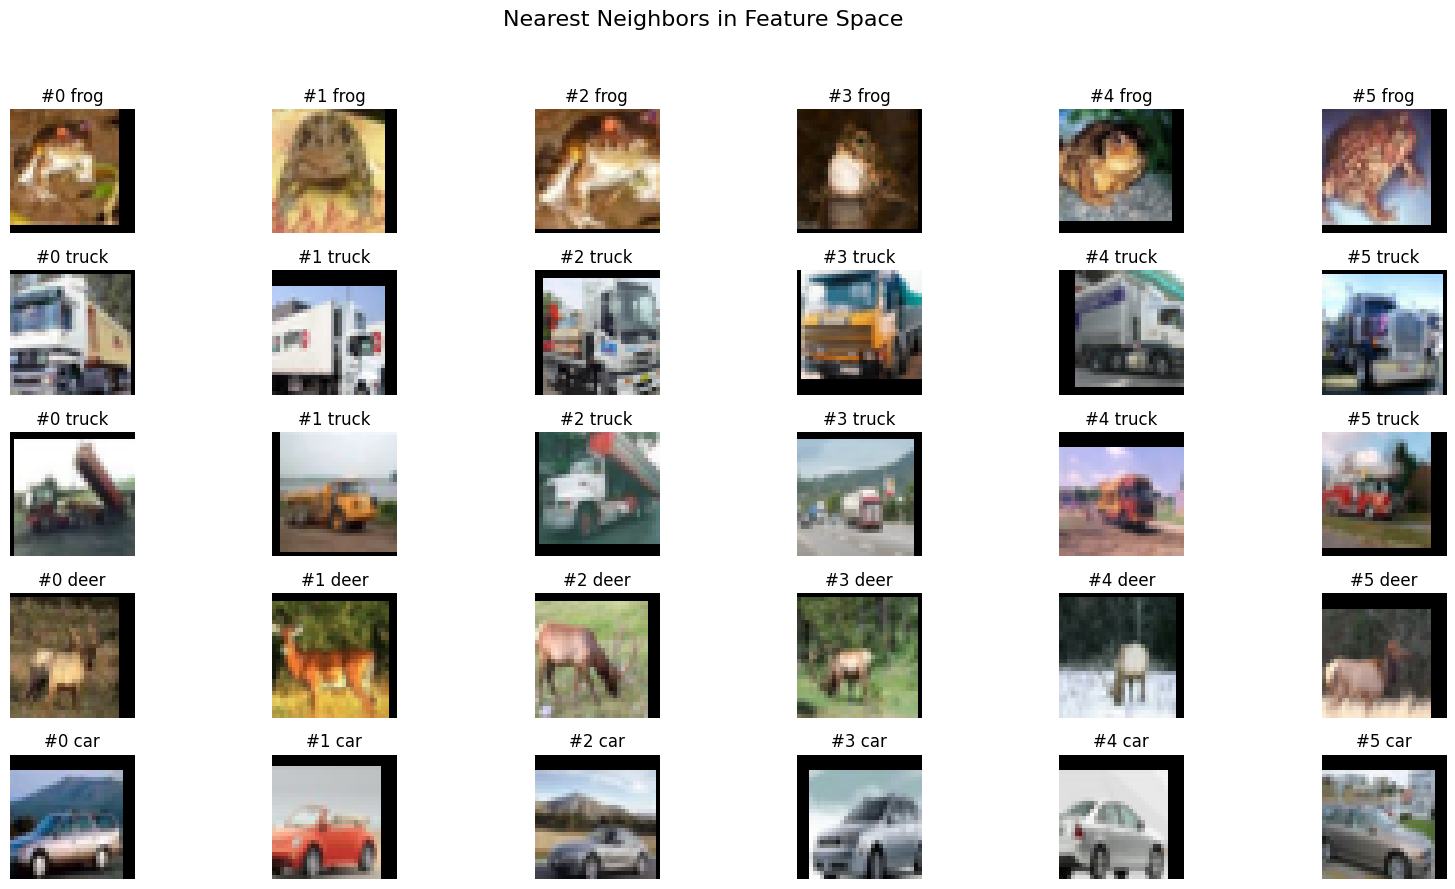

In [19]:
num_samples = 5

fig, axs = plt.subplots(num_samples, 6, figsize=(20, 10))
fig.suptitle('Nearest Neighbors in Feature Space', fontsize=16)

axs[0, 0].set_title('Test Image')
for i in range(1, 6):
    axs[0, i].set_title(f'#{i} Closest in Train')

with torch.no_grad():
    _, predicted = torch.max(model.fc(outputs), 1)

    for idx, (out, label, pred) in enumerate(zip(outputs, all_labels, predicted)):
        if num_samples == 0:
            break
        if pred == label:
            _, similar_indices = torch.topk(torch.linalg.norm(outputs - out, dim=1), k=6, largest=False)
            for i, sim_idx in enumerate(similar_indices):
                sim_img = norminv(all_inputs[sim_idx].cpu()).numpy()
                sim_img = (sim_img - sim_img.min()) / (sim_img.max() - sim_img.min())
                axs[5 - num_samples, i].imshow(sim_img.transpose(1, 2, 0))
                axs[5 - num_samples, i].axis('off')
                axs[5 - num_samples, i].set_title(f'#{i} {classes[all_labels[sim_idx].item()]}')
            num_samples -= 1

plt.subplots_adjust(wspace=0.1, hspace=0.3)
plt.show()


### TSNE

1. Sample $M$ ($2000$ would be enought) random samples from the trainset feature space (calculated in the above sections)
2. Now you have a vector of size `(M, N)` where $N$ is the dimension of the feature space
3. Using TSNE reduce $N$ to $2$ (Now you have a vector of size `(M, 2)`)
4. Visualize the points in a 2D plane (Set color of each point based on it's class)

**Hint:** You can use `sklearn.manifold.TSNE`

**Hint:** Use `plt.scatter(x, y, c=labels)`


<Axes: xlabel='x', ylabel='y'>

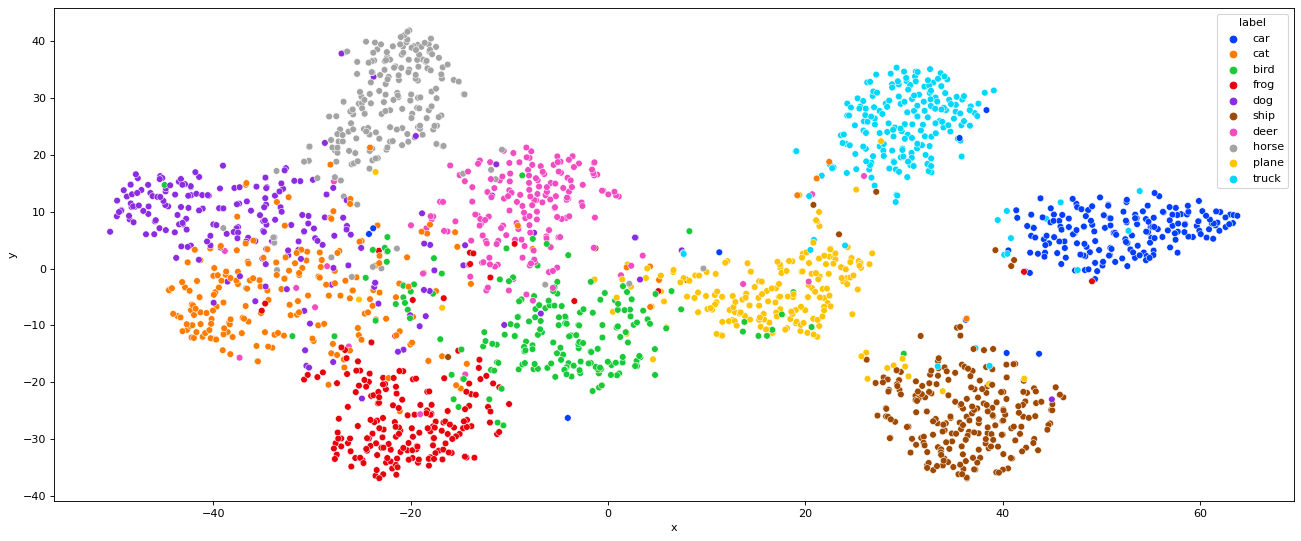

In [20]:
indices = torch.randperm(outputs.size(0))[:2000]

X = outputs[indices].cpu().numpy()
y = all_labels[indices].cpu().numpy()

X_2d = TSNE(2).fit_transform(X)

plt.figure(figsize=(20, 8), dpi=80)
data = pd.DataFrame({
    'x': X_2d[:,0],
    'y': X_2d[:,1],
    'label': [classes[t] for t in y],
})

cmap = sns.color_palette("bright", 10).as_hex()
sns.scatterplot(data=data, x='x', y='y', hue='label', palette = cmap)

# CIFAR10 Colorization

In this part of the assignment, we want to do an image colorization task using PyTorch on CIFAR10 dataset. We want to train a model that colors  a black-and-white image.

## Import Libraries

Import needed libraries

In [21]:
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

In [22]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## Custom Dataset

Define a custom dataset class by extensing `torch.utils.data.Dataset`

**Notice:** your dataset should output two things: black-and-white image and the RGB image

**Hint:** You don't have to reinvent the wheel. Your class should just be a wrapper for CIFAR10 dataset

In [23]:
class BlackAndWhiteCIFAR10(Dataset):
    """
    Define a custom dataset class by extending `torch.utils.data.Dataset`.
    This class is a dataset for the CIFAR10 data in PyTorch. It outputs the black-and-white image of the original CIFAR10 image as the data
    and the original RGB image as the target. This class is just a wrapper for the torchvision.datasets.CIFAR10 class.
    """

    def __init__(self, train=True, root='./data', download=True, transform= transforms.Grayscale()):

        self.cifar10_dataset = CIFAR10(root=root, train=train, download=download, transform=transforms.Compose([transforms.ToTensor()]))

        self.transform = transforms.Grayscale()

    def __len__(self):

        return len(self.cifar10_dataset)

    def __getitem__(self, index):

        img, _ = self.cifar10_dataset[index]
        return self.transform(img), img



## Transforms & Dataset & Dataloader

**Notice:** Use your defined custom dataset class for defining the datasets

In [24]:
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [25]:
transform = transforms.Compose([
    transforms.ToTensor(),
])

trainset = BlackAndWhiteCIFAR10(torchvision.datasets.CIFAR10(root='./', download=True, train=True, transform=transform))
validset = BlackAndWhiteCIFAR10(torchvision.datasets.CIFAR10(root='./', download=True, train=False, transform=transform))

train_loader = torch.utils.data.DataLoader(trainset, shuffle=True, num_workers=2, batch_size=128)
valid_loader = torch.utils.data.DataLoader(validset, shuffle=False, num_workers=2, batch_size=256)

Files already downloaded and verified


100%|██████████| 170498071/170498071 [00:02<00:00, 81734408.62it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Files already downloaded and verified


In [27]:
initial_trainset = BlackAndWhiteCIFAR10(root='./data', train=True,
                                        download=True, transform=transform_train)

Files already downloaded and verified


## Dataset Visualization

Visualize your dataset (black-and-white image along with the RGB image) by sampling from your trainset

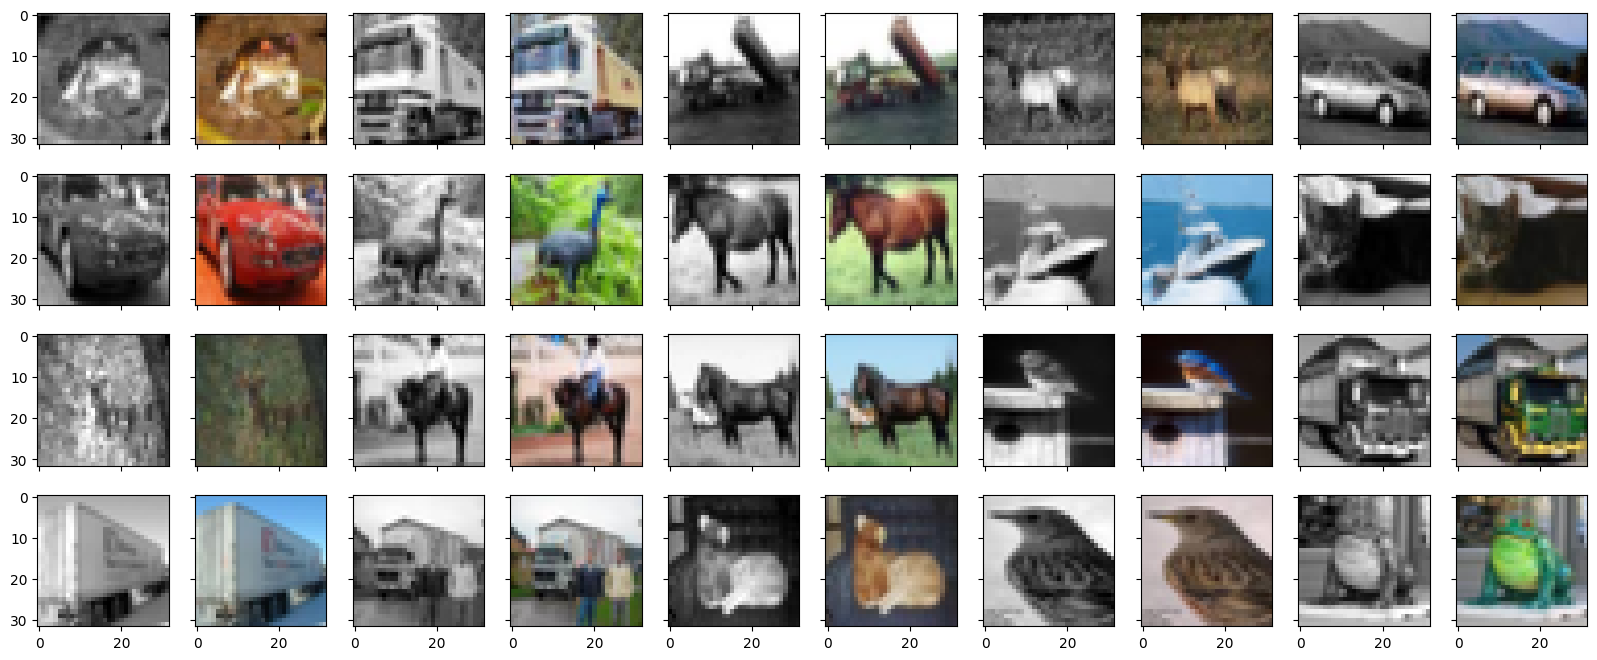

In [28]:
_, axs = plt.subplots(4, 10, sharex=True, sharey=True, figsize=(20, 8))

iterator = iter(trainset)

for i in range(20):
    bw, rgb = next(iterator)
    x, y = i // 5, 2 * (i % 5)
    axs[x, y].imshow(bw.numpy()[0], cmap='gray')
    axs[x, y + 1].imshow(rgb.numpy().transpose(1, 2, 0))

## Model

Define your model here (Input: black-and-white image, Output: RGB image)

**Hint:** You can implement an autoencoder that does the colorization task for you. UNet could be a viable option

In [29]:
class double_conv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(double_conv, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu1 = nn.LeakyReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.relu2 = nn.LeakyReLU(inplace=True)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        return x

class Up(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(Up, self).__init__()
        self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.conv = double_conv(in_ch, out_ch)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, (diffX // 2, (diffX + 1) // 2, diffY // 2, (diffY + 1) // 2))

        x = torch.cat([x2, x1], dim=1)
        x = self.conv(x)
        return x

class UNet(nn.Module):
    def __init__(self, n_classes):
        super(UNet, self).__init__()
        self.inc = double_conv(1, 64)
        
        self.down1 = nn.Sequential(
            nn.MaxPool2d(2),
            double_conv(64, 128)
        )
        self.down2 = nn.Sequential(
            nn.MaxPool2d(2),
            double_conv(128, 256)
        )
        self.down3 = nn.Sequential(
            nn.MaxPool2d(2),
            double_conv(256, 512)
        )
        self.down4 = nn.Sequential(
            nn.MaxPool2d(2),
            double_conv(512, 512)
        )
        self.up1 = Up(1024, 256)
        self.up2 = Up(512, 128)
        self.up3 = Up(256, 64)
        self.up4 = Up(128, 64)
        self.outc = nn.Conv2d(64, n_classes, 1)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        x = self.outc(x)
        return x


In [30]:
model = UNet(3).to(device)
summary(model, (1, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]             640
       BatchNorm2d-2           [-1, 64, 32, 32]             128
         LeakyReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4           [-1, 64, 32, 32]          36,928
       BatchNorm2d-5           [-1, 64, 32, 32]             128
         LeakyReLU-6           [-1, 64, 32, 32]               0
       double_conv-7           [-1, 64, 32, 32]               0
         MaxPool2d-8           [-1, 64, 16, 16]               0
            Conv2d-9          [-1, 128, 16, 16]          73,856
      BatchNorm2d-10          [-1, 128, 16, 16]             256
        LeakyReLU-11          [-1, 128, 16, 16]               0
           Conv2d-12          [-1, 128, 16, 16]         147,584
      BatchNorm2d-13          [-1, 128, 16, 16]             256
        LeakyReLU-14          [-1, 128,

## Train

Train your model

Tasks:
- [ ] Things that are needed to be printed in each epoch:
  - Number of epoch
  - Train loss
  - Validation loss
- [ ] save train/validation loss (of each epoch) in an array for later usage

In [31]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [32]:
def train_epoch(net, criterion, optimizer, dataloader):
    net.train()
    running_loss = 0.0
    for inputs, targets in dataloader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
    epoch_loss = running_loss / len(dataloader.dataset)
    return epoch_loss

def eval_epoch(net, criterion, dataloader):
    net.eval()
    running_loss = 0.0
    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, targets)
            running_loss += loss.item() * inputs.size(0)
    epoch_loss = running_loss / len(dataloader.dataset)
    return epoch_loss

In [33]:
epochs = 30

train_losses = []
val_losses = []
for e in range(epochs):
    print(f'Epoch {e+1}/{epochs}:')

    train_loss = train_epoch(model, criterion, optimizer, train_loader)
    train_losses.append(train_loss)
    print(f'Train Loss: {train_loss:.4f}')

    val_loss = eval_epoch(model, criterion, valid_loader)
    val_losses.append(val_loss)
    print(f'Validation Loss: {val_loss:.4f}')

Epoch 1/30:
Train Loss: 0.0144
Validation Loss: 0.0058
Epoch 2/30:
Train Loss: 0.0057
Validation Loss: 0.0059
Epoch 3/30:
Train Loss: 0.0055
Validation Loss: 0.0055
Epoch 4/30:
Train Loss: 0.0054
Validation Loss: 0.0053
Epoch 5/30:
Train Loss: 0.0054
Validation Loss: 0.0052
Epoch 6/30:
Train Loss: 0.0054
Validation Loss: 0.0056
Epoch 7/30:
Train Loss: 0.0053
Validation Loss: 0.0054
Epoch 8/30:
Train Loss: 0.0052
Validation Loss: 0.0051
Epoch 9/30:
Train Loss: 0.0052
Validation Loss: 0.0051
Epoch 10/30:
Train Loss: 0.0051
Validation Loss: 0.0052
Epoch 11/30:


KeyboardInterrupt: 

### Visualize Loss plot

Using the arrays that you have (from task 2 in the above section), visualize the loss plot (train and validation together)

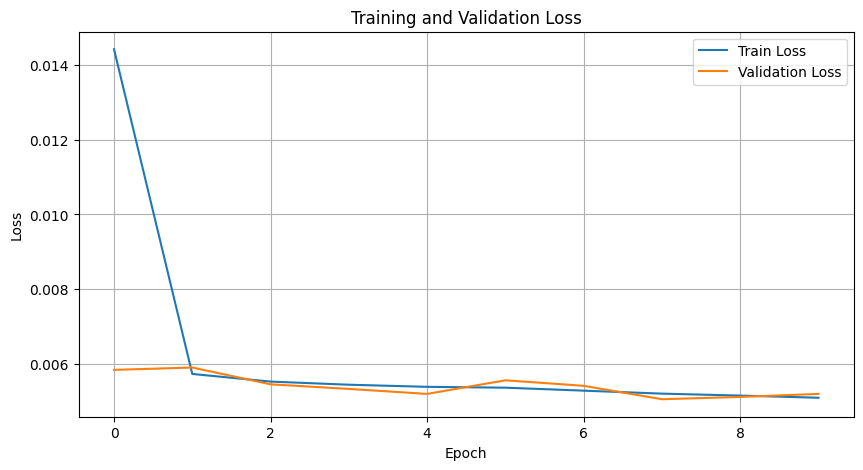

In [34]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

## Evaluation

1. Sample 36 random samples from testset (your own dataset class)
2. Give each of the 36 samples to your trained model and get the outputs
3. Visualize `input` (black-and-white image), `output` (output of the model with the given black-and-white input image) and `ground truth` (the actual RGB image)



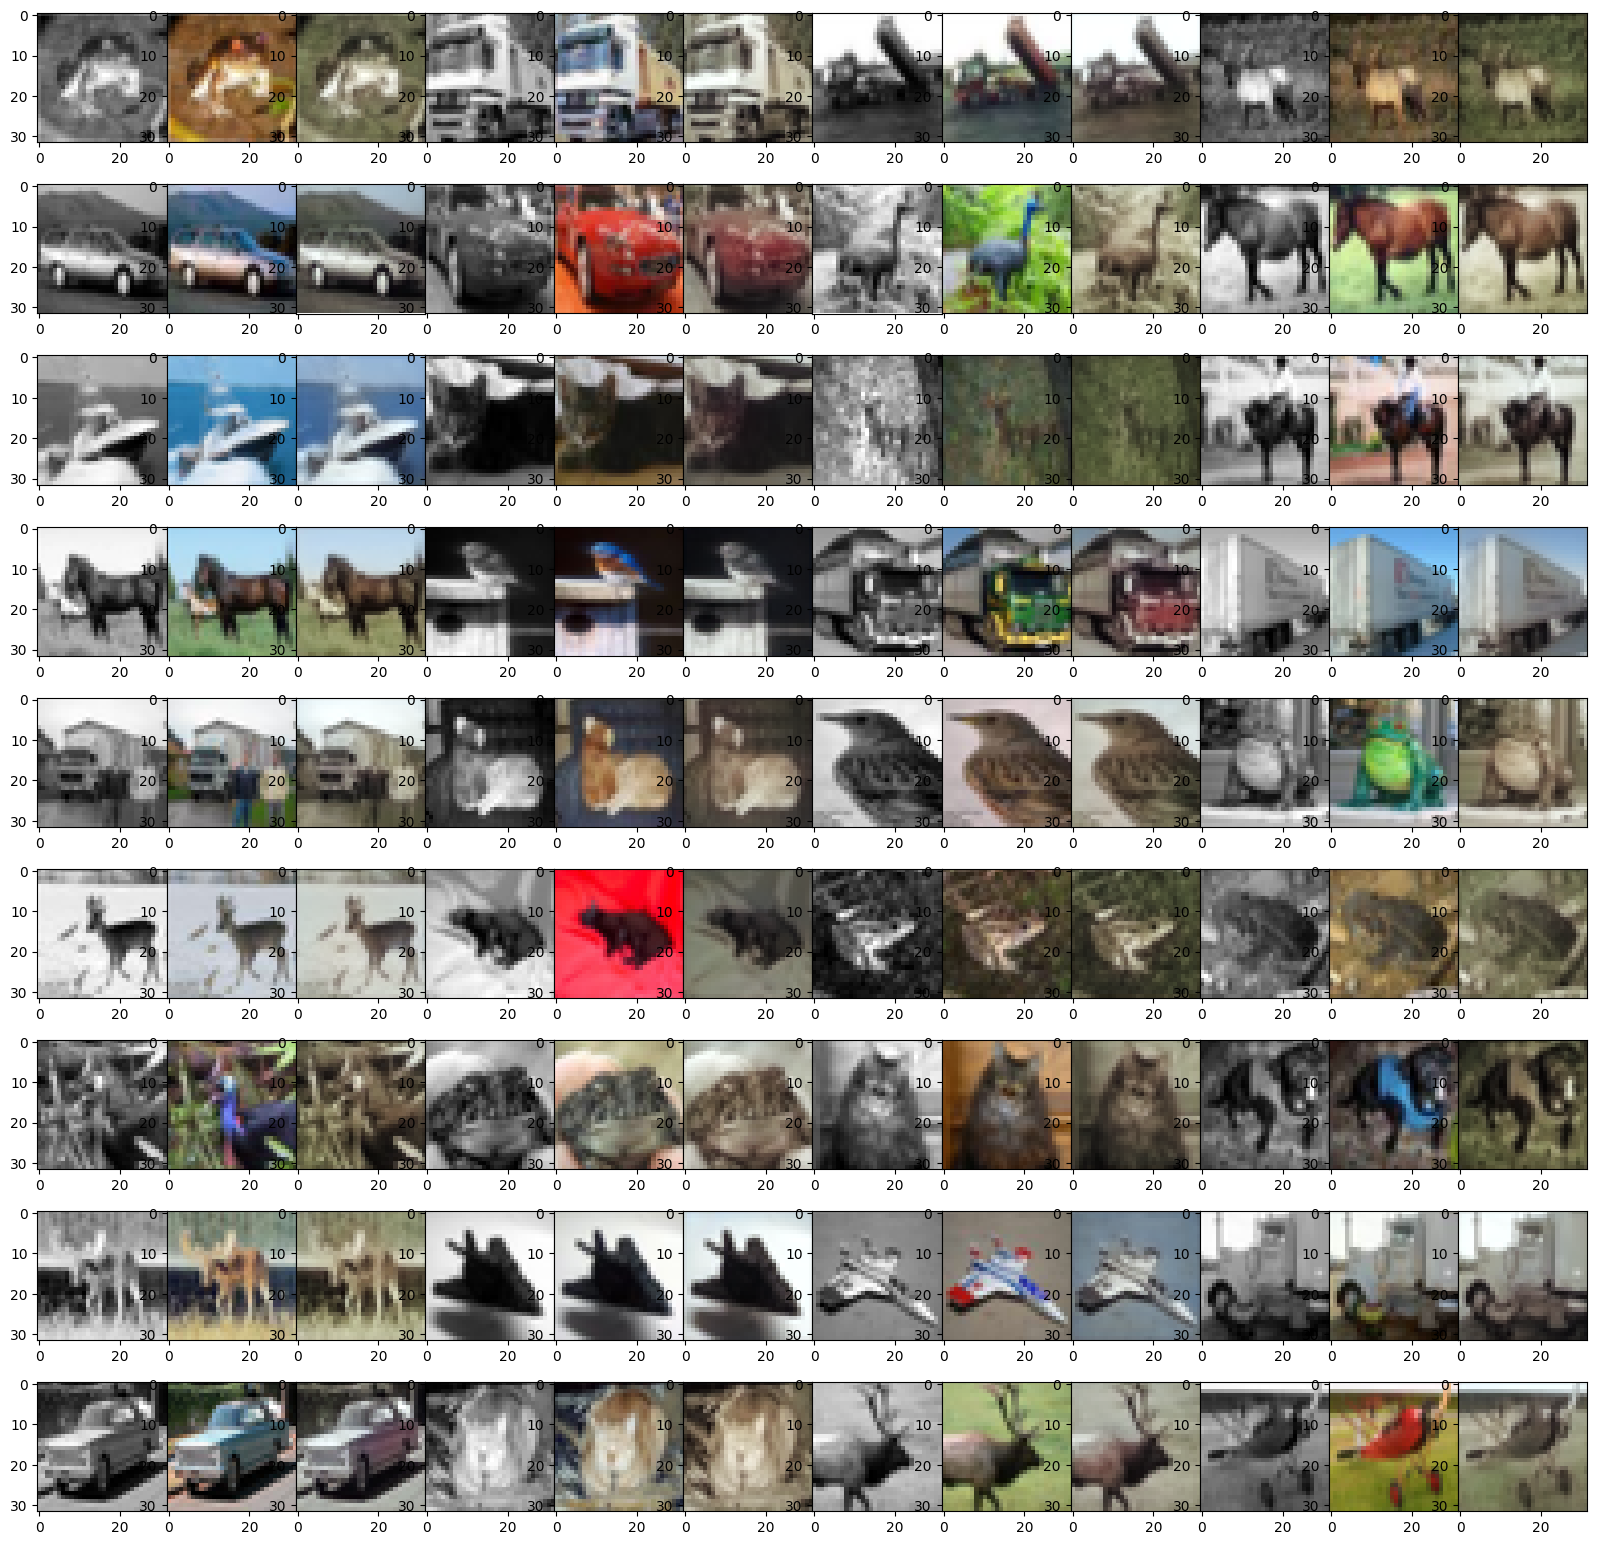

In [35]:
_, axs = plt.subplots(9, 12, figsize=(20, 20))

data = next(iter(valid_loader))
inputs, labels = data[0].to(device), data[1].to(device)
with torch.no_grad():
    outputs = model(inputs)

for i in range(36):
    bw = inputs[i]
    rgb = labels[i]
    predict = outputs[i]
    x, y = (i // 4), 3 * (i % 4)
    axs[x, y].imshow(bw.cpu().numpy()[0], cmap='gray')
    axs[x, y + 1].imshow(rgb.cpu().numpy().transpose(1, 2, 0))
    axs[x, y + 2].imshow(predict.cpu().numpy().transpose(1, 2, 0))

plt.subplots_adjust(wspace=0, hspace=0)